# Auto-encoders for Document Denoising

## About Autoencoders
An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name.

![](https://osclasspoint.com/kaggle/autoencoder.png)

## Import libraries and data
First load libraries we need for our work. We need multiple libraries to be able to unzip files, work with directories, sklearn, tensorflow...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [ ]:
# special need for Google Colab
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/ColabNotebooks/DocDenoise")
!ls

Mounted at /content/drive
autoencoders.ipynb  checkpoints  cycleGAN.ipynb  data  images  zip


In [ ]:
# check GPU details
!nvidia-smi

Sat Jun 18 16:03:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

As we have data zipped, we will have to work in `./data/` directory to unzip images here.

In [ ]:
# path to zipped & working directories
path_zip = 'zip/'
path = 'data/'

In [ ]:
# unzip files first to working directory
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

For later use, we will store image names into list, so we can draw them simply.

In [ ]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))
test_invoice_img = sorted(os.listdir(path + '/test_invoice'))

## Data preparation
Next step is to define function to process images and then store this images in list. As there is not as many data, we do not need to work in batches.

In [ ]:
IMG_WIDTH = 540
IMG_HEIGHT = 420

# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
    
    return img

Reshape images and put them into list.

In [ ]:
# preprocess images
train = []
train_cleaned = []
test = []
test_invoice = []

for f in train_img:
    train.append(process_image(path + 'train/' + f))

for f in train_cleaned_img:
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
    
for f in test_img:
    test.append(process_image(path + 'test/' + f))
    
for f in test_invoice_img:
    test_invoice.append(process_image(path + 'test_invoice/' + f))

## Exploratory data analysis
Not too much to look there, but just quickly look on train images and their cleaned version. This is what we put into model to learn how to clean noise from background.

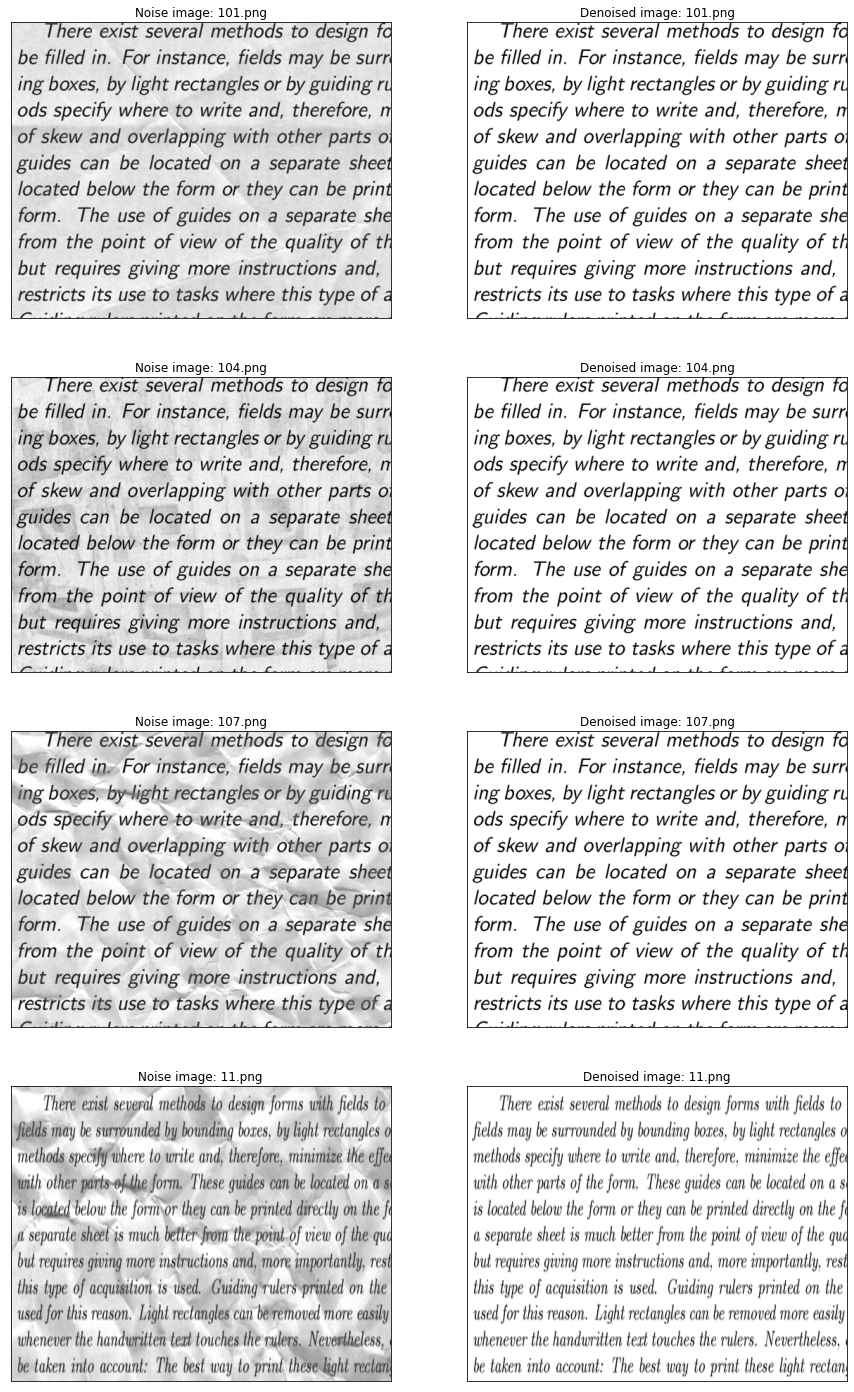

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

## Split data
In this step we convert lists to numpy arrays and split dataset into train and validation in ration 85% train, 15% test.

In [ ]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)
X_test_invoice = np.asarray(test_invoice)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

## Modeling
It's nice to look at model summary how it works in terms of layer sizes: 420x540 -> 210x270 --> 210x270 -> 420x540

Adam as optimizer is used (as it worked best out of other optimizers), loss is based on mean squared error and we are looking on mean absolute error as well.

In [ ]:
def model():
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

### Train model
We will run 80 epochs having early stopping set to 10 (if val loss does not drop in 10 epochs, it will stop).

Let's store history of model as well, so we can plot loss (rmse) and mae.

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=80, batch_size=12, verbose=1, callbacks=[callback])

Epoch 1/80
11/11 [==============================] - 25s 2s/step - loss: 0.1265 - mae: 0.2592 - val_loss: 0.1780 - val_mae: 0.4096
Epoch 2/80
11/11 [==============================] - 8s 709ms/step - loss: 0.0493 - mae: 0.1601 - val_loss: 0.1240 - val_mae: 0.3399
Epoch 3/80
11/11 [==============================] - 8s 714ms/step - loss: 0.0343 - mae: 0.1270 - val_loss: 0.0860 - val_mae: 0.2705
Epoch 4/80
11/11 [==============================] - 8s 720ms/step - loss: 0.0271 - mae: 0.1096 - val_loss: 0.0700 - val_mae: 0.2234
Epoch 5/80
11/11 [==============================] - 8s 727ms/step - loss: 0.0225 - mae: 0.0967 - val_loss: 0.0654 - val_mae: 0.1970
Epoch 6/80
11/11 [==============================] - 8s 736ms/step - loss: 0.0191 - mae: 0.0888 - val_loss: 0.0646 - val_mae: 0.1724
Epoch 7/80
11/11 [==============================] - 8s 743ms/step - loss: 0.0160 - mae: 0.0860 - val_loss: 0.0660 - val_mae: 0.1578
Epoch 8/80
11/11 [==============================] - 8s 753ms/step - loss: 0.01

Alternatively, we can load the saved model weight directly:

In [ ]:
# Restore the weights
model.load_weights('./checkpoints/autoencoders/my_checkpoint')

### Plot error evolution on epochs
You may notice jump in error after approx. 5 epoch that is pretty important, but enought epochs flatten this to almost 0.

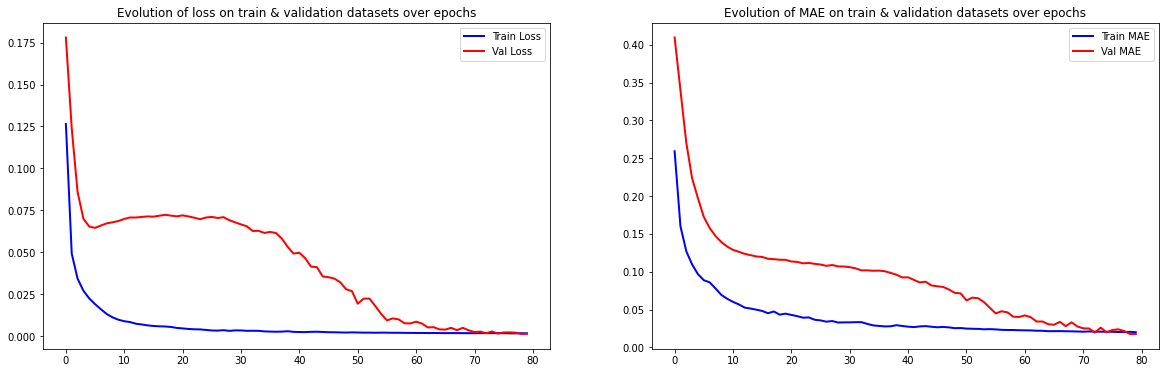

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

### Save model
Save the model weight in `./checkpoints/autoencoders/my_checkpoint`

In [ ]:
# Save the weights
model.save_weights('./checkpoints/autoencoders/my_checkpoint')

## Evaluation
In this step we will "predict", or better say clean test images and check how well model works.

In [ ]:
# predict/clean test images
Y_test = model.predict(X_test[:4])
Y_test_invoice = model.predict(X_test_invoice)

Now compare noisy (left) and denoised test images (right). Our model has done great job with denoising!

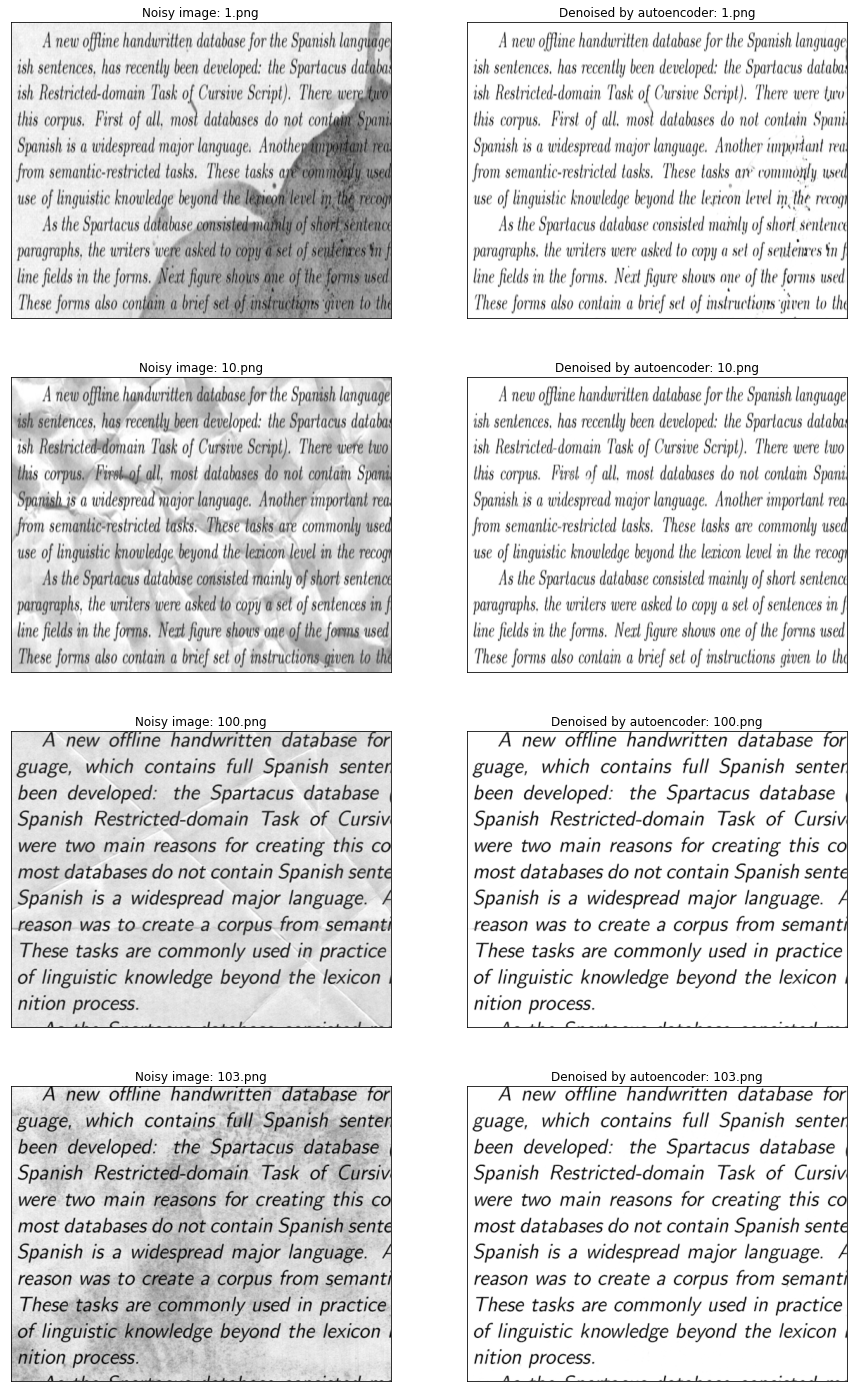

In [ ]:
plt.figure(figsize=(15,25))

for i in range(0,8,2):
  index = int(i/2)
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_test[index][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[index]))
  
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(Y_test[index][:,:,0], cmap='gray')
  plt.title('Denoised by autoencoder: {}'.format(test_img[index]))

plt.show()

Check the performance on other kind of document - invoice, that has multiple kinds of noise in daily lives. It's shown that it could perform well on half of the images.

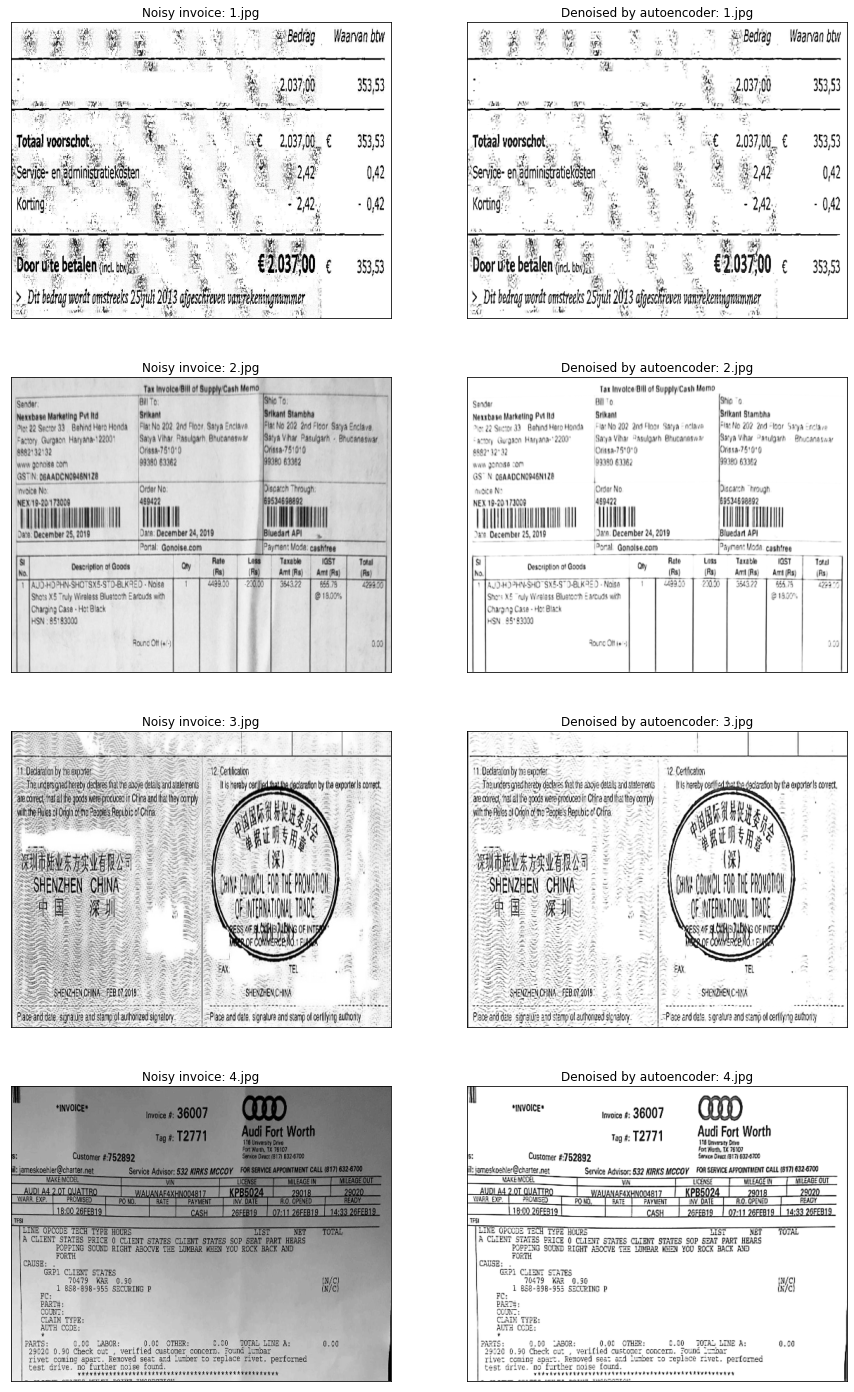

In [ ]:
plt.figure(figsize=(15,25))
    
for i in range(0,8,2):
    index = int(i/2)
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test_invoice[index][:,:,0], cmap='gray')
    plt.title('Noisy invoice: {}'.format(test_invoice_img[index]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test_invoice[index][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_invoice_img[index]))
    
plt.show()

## Next steps

Training the model on a larger dataset, and tuning parameters to achieve greater performance